In [2]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import odeint, solve_ivp
from tqdm import tqdm

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

# Print only 4 decimals
np.set_printoptions(precision=4)
torch.set_printoptions(precision=4)

PATH = "../data/"

def get_data(exp_id: str, batch: bool = True) -> pd.DataFrame:
    xls = pd.ExcelFile(PATH + f"{exp_id}_for_model.xlsx")
    df = xls.parse(0)
    df.drop(0, inplace=True)
    df['exp_id'] = exp_id
    if batch:
        df = df[df["Batch"] == 0]
    return df

def concat_data():
    return pd.concat([get_data(exp_id=exp_id, batch=True) for exp_id in ["BR01", "BR02", "BR03", "BR04", "BR05", "BR06", "BR07", "BR08", "BR09"]], ignore_index=True)

def get_training_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    t_train = df['Time'].values
    u_train = df[['Biomass', 'Glucose']].values
    return np.float32(t_train), np.float32(u_train)

def ode_func(t, y, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S)
    return [mu * X, -1 / Y_XS * mu * X]

Using device cuda


#### Get training data

In [3]:
df = concat_data()

print(f'Dataset shape: {df.shape}')

Dataset shape: (53, 10)


#### Physics Informed Neural Network

In [4]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.input = nn.Linear(1, 10)
        self.hidden = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.mu_max = nn.Parameter(torch.tensor(0.5))
        self.Km = nn.Parameter(torch.tensor(0.5))
        self.Y_XS = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

#### Create model

In [9]:
model = PINN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

#### Training loop

In [10]:
n_samples = 100
def physics_loss(model: nn.Module, t_start, t_end):
    t = torch.linspace(t_start, t_end, n_samples, device=device, requires_grad=True).reshape(-1,1)
    u = model(t).to(device)
    u_X = u[:,0].view(-1,1)
    u_S = u[:,1].view(-1,1)
    u_t_X = torch.autograd.grad(u_X, t, grad_outputs=torch.ones_like(u_X), create_graph=True)[0]
    u_t_S = torch.autograd.grad(u_S, t, grad_outputs=torch.ones_like(u_S), create_graph=True)[0]
    error_X = u_t_X - model.mu_max * u_X * u_S / (u_S + model.Km)
    error_S = u_t_S + 1 / model.Y_XS * model.mu_max * u_X * u_S / (u_S + model.Km)
    return torch.mean(error_X**2) + torch.mean(error_S**2)

In [13]:
EPOCHS = 10000
LOSS = []
# TODO: Cacluate mean loss of batch to LOSS of epoch
for epoch in tqdm(range(EPOCHS)):
    for _ in df['exp_id']:
        t_train = np.float32(df[df['exp_id']==_]['Time'].values)
        u_train = np.float32(df[df['exp_id']==_][['Biomass', 'Glucose']].values)

        ts_train = torch.tensor(t_train, requires_grad=True, device=device, dtype=torch.float32).view(-1, 1)
        us_train = torch.tensor(u_train, requires_grad=True, device=device, dtype=torch.float32)

        t_start = t_train.min()
        t_end = t_train.max()

        # training
        optimizer.zero_grad()
        u_pred = model.forward(ts_train)
        
        # Data Loss
        loss = criterion(u_pred, us_train)
        # ODE Loss
        loss_ode = physics_loss(model, t_start, t_end)
        # IC Loss
        loss_ic = criterion(u_pred[0], us_train[0])

        # Add losses 
        loss = loss + 0.2*loss_ode + loss_ic 
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.4f}, DATA Loss: {loss:.4f}, ODE Loss: {loss_ode:.4f}")
        print(f"mu_max: {model.mu_max.item():.4f}, Km: {model.Km.item():.4f}, Y_XS: {model.Y_XS.item():.4f}")


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.4251, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4233, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4215, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4198, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4180, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4163, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4146, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4128, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5861, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5676, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5494, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5315, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2196, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2191, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2186, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2182, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1405, device='cuda:0', grad_fn=

  0%|          | 1/10000 [00:00<58:38,  2.84it/s]

tensor(2.5578, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5499, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5421, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5267, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5190, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7748, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7623, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7500, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7377, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7256, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7136, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5703, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5622, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5540, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5460, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1849, device='cuda:0', grad_fn=

  0%|          | 2/10000 [00:00<50:55,  3.27it/s]

tensor(1.1078, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0987, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0897, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0809, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0721, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3166, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3038, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2912, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2788, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2666, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2545, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2427, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2310, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5635, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5557, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5478, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5401, device='cuda:0', grad_fn=

  0%|          | 3/10000 [00:00<48:39,  3.42it/s]

tensor(1.5666, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5586, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5506, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1904, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1809, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1714, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1620, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4294, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4276, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4258, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4241, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4223, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4206, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4188, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4171, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.6001, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5820, device='cuda:0', grad_fn=

  0%|          | 4/10000 [00:01<47:38,  3.50it/s]

tensor(2.5600, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5522, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5445, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5368, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5292, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5217, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5142, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7817, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7693, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7571, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7450, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7329, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7210, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5764, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5683, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5603, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5523, device='cuda:0', grad_fn=

  0%|          | 5/10000 [00:01<47:00,  3.54it/s]

tensor(1.1092, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1001, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0912, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0824, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0738, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0652, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3080, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2954, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2830, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2707, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2587, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2469, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2352, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2237, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5586, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5509, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5432, device='cuda:0', grad_fn=

  0%|          | 6/10000 [00:01<46:37,  3.57it/s]

tensor(2.7243, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5790, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5709, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5629, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5549, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1954, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1860, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1765, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1671, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4317, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4299, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4281, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4263, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4246, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4228, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4210, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4193, device='cuda:0', grad_fn=

  0%|          | 7/10000 [00:02<46:14,  3.60it/s]

tensor(1.2321, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2207, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5565, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5487, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5410, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5334, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5259, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5184, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5109, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7862, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7739, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7616, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7495, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7375, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7256, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5800, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5719, device='cuda:0', grad_fn=

  0%|          | 8/10000 [00:02<46:32,  3.58it/s]

tensor(0.2181, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1236, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1144, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1053, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0963, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0875, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0787, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0701, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0616, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3034, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2909, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2785, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2664, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2544, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2426, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2310, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2196, device='cuda:0', grad_fn=

  0%|          | 9/10000 [00:02<46:29,  3.58it/s]

tensor(2.7759, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7636, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7515, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7395, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.7276, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5816, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5735, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5654, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5575, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1983, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1888, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1794, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1700, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4330, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4312, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4294, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4276, device='cuda:0', grad_fn=

  0%|          | 9/10000 [00:02<51:02,  3.26it/s]


tensor(1.2768, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2647, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2527, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2409, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2293, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2179, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5542, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5465, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5388, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5312, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5237, device='cuda:0', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

mu_max: 0.8101586103439331
Km: 1.1655222177505493
Y_XS: 0.4819657504558563


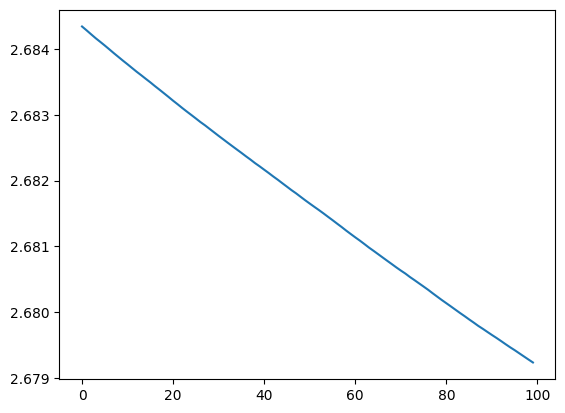

In [120]:
# Tranform LOSS from tensor to numpy
LOSS = [l.item() for l in LOSS]

print(f'mu_max: {model.mu_max.item()}')
print(f'Km: {model.Km.item()}')
print(f'Y_XS: {model.Y_XS.item()}')

# Plot LOSS 
plt.plot(LOSS)
plt.yscale('log')
plt.show()